# OLD STUFF THAT I WANNA KEEP - DONT BOTHER LOOKING

In [ ]:
net_search_space2 = {
    #'num_layers': hp.uniformint('num_layers', 5, 15),  # choose between the number of layers
    #'compression_ratio': hp.uniform('compression_ratio', 0.5, 0.9),
    #'min_layer_size': hp.uniformint('min_layer_size', 8, 30),
    'epochs': hp.uniformint('epochs', 5, 25),
    #'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    #'activation': hp.choice('activation', [nn.ReLU(), nn.Tanh()]),
    #'dropout': hp.loguniform('dropout', 1e-5, 0.001)
}
net = imbPipeline([
    ('dim_reductor', big_dim_reductor),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=RANDOM_STATE,n_jobs=-1)),
    ('model', PyTorchClassifier(input_size, 5, layers_sizes))
])
best_params = optimize_classifier(X, y5, net, net_search_space2, {}, max_evals=5, scoring='accuracy',n_jobs=1, debug=True, search_features=False)
evaluate_classifier(net, X, y5)

In [ ]:
net_search_space = {
    'num_layers': hp.choice('num_layers', np.arange(1, 15, 1, dtype=int)),  # choose between the number of layers
    'units_per_layer': hp.choice('units_per_layer', [
        [hp.randint(f'units_layer_{i}_{j}', 20, 150) for i in range(j)]  # each layer can have between 50 to 150 units
        for j in range(1, 5)  # corresponding to the number of layers chosen
    ]),
    'epochs': hp.uniformint('epochs', 5, 25),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'activation': hp.choice('activation', [nn.ReLU(), nn.Tanh()]),
    'dropout': hp.loguniform('dropout', 1e-5, 0.1)
}

In [ ]:
## CELL NOT USED BECAUSE REDUCES FINAL SCORE
from sklearn.base import clone

# Function to ensure all classifiers can predict probabilities
def prepare_estimators_with_probabilities(models_dict):
    models_tuples = []
    for name, pipeline in models_dict.items():
        # Clone the entire pipeline first
        new_pipeline = clone(pipeline)
        model = new_pipeline.named_steps['model']
        
        # Check if the model is of a class that typically requires enabling probabilities
        if hasattr(model, 'probability') and not model.probability:
            # Set probability parameter to True
            model.set_params(probability=True)
        elif not hasattr(model, 'predict_proba'):
            raise ValueError(f"The model {name} does not support probability predictions and cannot be adjusted to do so.")
        
        # After updating the model in the cloned pipeline, append to list
        models_tuples.append((name, new_pipeline))
    
    return models_tuples

models_tuples_proba = prepare_estimators_with_probabilities(models)
models_tuples_proba = [(name, pipeline) for name, pipeline in models_tuples_proba]

In [ ]:
scores = []
for i in range(10,15):
    print('Testing random state ', i)
    cv2 = StratifiedKFold(n_splits=4, random_state=i, shuffle=True)
    check_splits(X, y, cv2)
    accuracy = evaluate_classifier(voting_pipe, X, y5, cv=cv2)
    scores.append(accuracy)
print(f"Mean accuracy: {np.mean(scores):.4f}")

In [ ]:
# Meta-model (can be any other classifier)
models2 = models.copy()
models2['et'].named_steps['adasyn'].n_neighbors = models2['et'].named_steps['adasyn'].n_neighbors - 1
models2['et'].named_steps['adasyn'].n_neighbors
meta_model = LGBMClassifier()
meta_model_search_space = {
    'final_estimator__num_leaves': hp.choice('final_estimator__num_leaves', [10, 20, 30, 40, 50]),
    'final_estimator__max_depth': hp.choice('final_estimator__max_depth', [5, 10, 15, 20, 30, 40]),
    'final_estimator__learning_rate': hp.loguniform('final_estimator__learning_rate', np.log(0.01), np.log(0.2)),
    'final_estimator__min_child_samples': hp.choice('final_estimator__min_child_samples', [5, 10, 20, 30]),
    'final_estimator__subsample': hp.uniform('final_estimator__subsample', 0.5, 1),
    'final_estimator__colsample_bytree': hp.uniform('final_estimator__colsample_bytree', 0.5, 1),
}

# This ensures that the search space now correctly targets parameters of the final_estimator

# Create the stacking classifier
stack_clf = StackingClassifier(
    estimators=[(name, model) for name, model in models2.items()],
    final_estimator=meta_model,
    n_jobs=1
)
stack_pipe = imbPipeline([
    ('model', stack_clf)
])
#best_params_stack = optimize_classifier(X, y, stack_pipe, meta_model_search_space, {}, max_evals=100, scoring='accuracy')
evaluate_classifier(stack_pipe, X, y, n_jobs=1)


[0 1 2 4]
Accuracy: 0.8755020080321285
Precision: 0.8420701930330997
Recall: 0.8755020080321285
F1 Score: 0.8576068813500192
              precision    recall  f1-score   support

         Bee       0.84      0.93      0.88       115
   Bumblebee       0.92      0.92      0.92       100
   Butterfly       0.79      0.73      0.76        15
       Other       0.00      0.00      0.00        10
        Wasp       1.00      0.89      0.94         9

    accuracy                           0.88       249
   macro avg       0.71      0.69      0.70       249
weighted avg       0.84      0.88      0.86       249



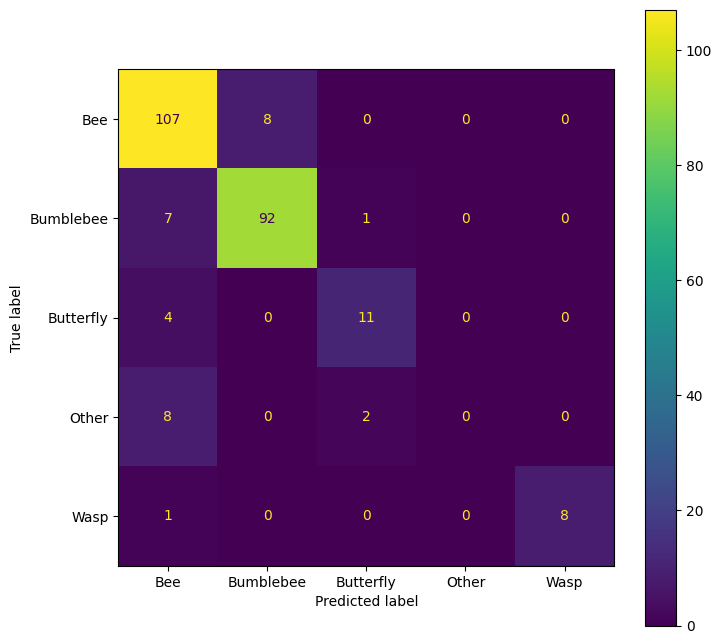

In [ ]:
rbf_svc = imbPipeline([ 
    ('scaler', DataFrameStandardScaler()),
    ('smote', SMOTE(random_state=RANDOM_STATE, n_jobs=-1)),
    ('feature_selector', feature_selector),
    ('model', SVC(max_iter=10000))])
rbf_svc.set_params(**{'model__C': 0.9463677818791373, 'model__gamma': 'auto', 'model__kernel': 'rbf', 'feature_selector__feature_flags': {'aspect_ratio': 0, 'axis_least_inertia_x': 0, 'axis_least_inertia_y': 0, 'blue_contrast': 1, 'blue_mask_max': 1, 'blue_mask_mean': 0, 'blue_mask_median': 0, 'blue_mask_min': 1, 'blue_mask_q1': 0, 'blue_mask_q3': 0, 'blue_mask_std': 0, 'blue_rest_max': 1, 'blue_rest_mean': 1, 'blue_rest_median': 1, 'blue_rest_min': 1, 'blue_rest_q1': 1, 'blue_rest_q3': 0, 'blue_rest_std': 0, 'body_parts_max_length': 0, 'body_parts_mean_length': 0, 'body_parts_spread': 1, 'body_parts_std_length': 1, 'ellipse_angle': 1, 'ellipse_axis_ratio': 0, 'ellipse_eccentricity': 0, 'ellipse_variance': 1, 'fourier_descriptor_imag_0': 0, 'fourier_descriptor_imag_1': 1, 'fourier_descriptor_imag_2': 0, 'fourier_descriptor_imag_3': 0, 'fourier_descriptor_imag_4': 0, 'fourier_descriptor_imag_5': 0, 'fourier_descriptor_imag_6': 0, 'fourier_descriptor_imag_7': 0, 'fourier_descriptor_imag_8': 1, 'fourier_descriptor_imag_9': 1, 'fourier_descriptor_real_0': 0, 'fourier_descriptor_real_1': 1, 'fourier_descriptor_real_2': 1, 'fourier_descriptor_real_3': 0, 'fourier_descriptor_real_4': 0, 'fourier_descriptor_real_5': 0, 'fourier_descriptor_real_6': 1, 'fourier_descriptor_real_7': 1, 'fourier_descriptor_real_8': 0, 'fourier_descriptor_real_9': 1, 'green_mask_max': 0, 'green_mask_mean': 0, 'green_mask_median': 1, 'green_mask_min': 1, 'green_mask_q1': 1, 'green_mask_q3': 1, 'green_mask_std': 0, 'green_rest_max': 0, 'green_rest_mean': 0, 'green_rest_median': 1, 'green_rest_min': 0, 'green_rest_q1': 0, 'green_rest_q3': 1, 'green_rest_std': 0, 'hue_mask_max': 0, 'hue_mask_mean': 1, 'hue_mask_median': 1, 'hue_mask_q1': 0, 'hue_mask_q3': 1, 'hue_mask_std': 1, 'hue_rest_max': 0, 'hue_rest_mean': 0, 'hue_rest_median': 1, 'hue_rest_q1': 1, 'hue_rest_q3': 0, 'hue_rest_std': 0, 'hull_area': 0, 'hull_convexity': 0, 'hull_to_insect_area_ratio': 0, 'hull_to_insect_area_ratio_x_value_mask_std': 0, 'hull_triangle_similarity': 0, 'image_symmetry_index': 0, 'kurtosis_centroid_distance': 0, 'mask_area': 1, 'mask_bb_symmetry_index': 1, 'mask_entropy': 1, 'mask_perimeter': 1, 'max_centroid_distance': 1, 'mean_centroid_distance': 0, 'mean_centroid_distance_x_max_centroid_distance': 1, 'min_centroid_distance': 1, 'min_centroid_distance_x_rectangularity': 0, 'nb_pixels_ratio': 1, 'nb_pixels_ratio_div_hull_triangle_similarity': 1, 'orthogonal_lines_ratio': 1, 'rectangularity': 1, 'red_mask_max': 0, 'red_mask_mean': 1, 'red_mask_median': 1, 'red_mask_min': 1, 'red_mask_q1': 0, 'red_mask_q3': 0, 'red_mask_std': 1, 'red_rest_max': 0, 'red_rest_mean': 1, 'red_rest_median': 0, 'red_rest_min': 1, 'red_rest_q1': 0, 'red_rest_q3': 0, 'red_rest_std': 0, 'rest_entropy': 0, 'roundness': 0, 'roundness_div_hull_area': 1, 'saturation_mask_max': 0, 'saturation_mask_mean': 1, 'saturation_mask_median': 1, 'saturation_mask_min': 0, 'saturation_mask_q1': 1, 'saturation_mask_q3': 1, 'saturation_mask_std': 1, 'saturation_rest_max': 0, 'saturation_rest_mean': 0, 'saturation_rest_median': 1, 'saturation_rest_min': 0, 'saturation_rest_q1': 1, 'saturation_rest_q3': 1, 'saturation_rest_std': 0, 'saturation_weighted_aspect_ratio': 1, 'shape_texture_index': 0, 'skewness_centroid_distance': 1, 'std_centroid_distance': 1, 'value_mask_max': 0, 'value_mask_mean': 0, 'value_mask_median': 1, 'value_mask_min': 1, 'value_mask_q1': 0, 'value_mask_q3': 0, 'value_mask_std': 1, 'value_rest_max': 1, 'value_rest_mean': 1, 'value_rest_median': 0, 'value_rest_min': 0, 'value_rest_q1': 0, 'value_rest_q3': 0, 'value_rest_std': 0}}
)
evaluate_classifier(rbf_svc, X, y5, n_jobs=-1, plot=False)

[0 1 2 4]
Accuracy: 0.8473895582329317
Precision: 0.8135741043969154
Recall: 0.8473895582329317
F1 Score: 0.8297629648475767
              precision    recall  f1-score   support

         Bee       0.84      0.89      0.86       115
   Bumblebee       0.85      0.90      0.87       100
   Butterfly       0.86      0.80      0.83        15
       Other       0.00      0.00      0.00        10
        Wasp       0.88      0.78      0.82         9

    accuracy                           0.85       249
   macro avg       0.68      0.67      0.68       249
weighted avg       0.81      0.85      0.83       249



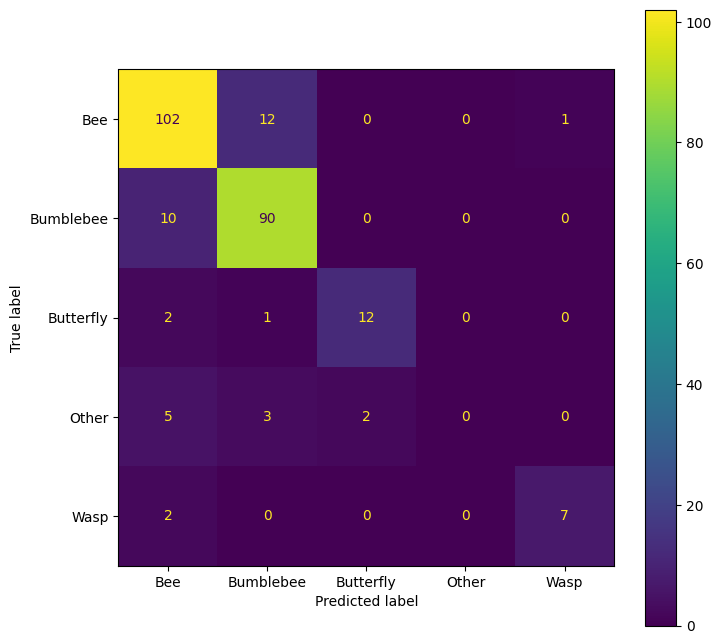

In [ ]:
et = imbPipeline([
    ('dim_reductor', big_dim_reductor),
    ('scaler', StandardScaler()),
    ('adasyn', adasyn),
    ('model', ExtraTreesClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])
et.set_params(**{'adasyn__n_neighbors': 3, 'model__max_depth': 20, 'model__max_features': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 0.1150066816318824, 'model__n_estimators': 200})
evaluate_classifier(et, X, y5, n_jobs=-1, plot=False)

[0 1 2 3 4]
Accuracy: 0.8995983935742972
Precision: 0.8951344122220779
Recall: 0.8995983935742972
F1 Score: 0.8949744711304078
              precision    recall  f1-score   support

         Bee       0.89      0.95      0.92       115
   Bumblebee       0.93      0.94      0.94       100
   Butterfly       0.85      0.73      0.79        15
       Other       0.67      0.40      0.50        10
        Wasp       0.86      0.67      0.75         9

    accuracy                           0.90       249
   macro avg       0.84      0.74      0.78       249
weighted avg       0.90      0.90      0.89       249



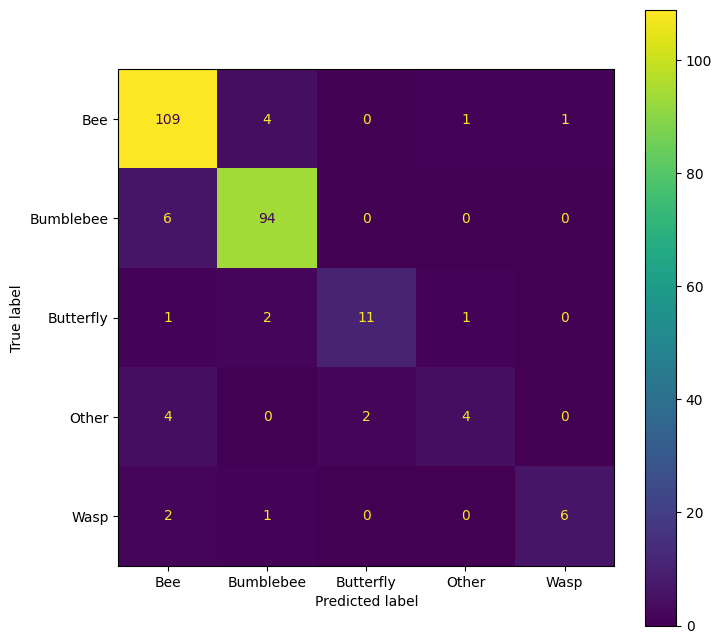

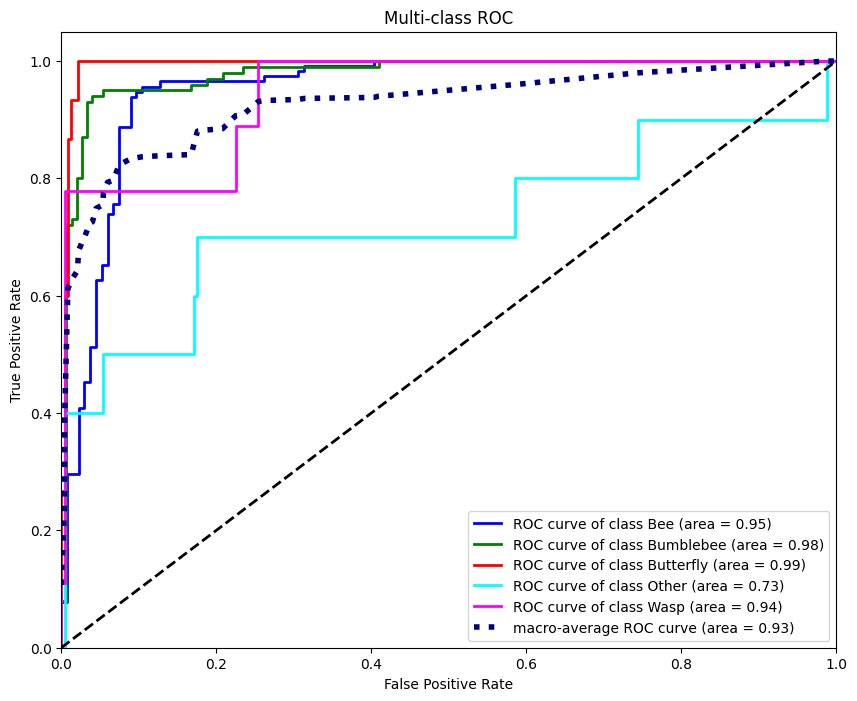

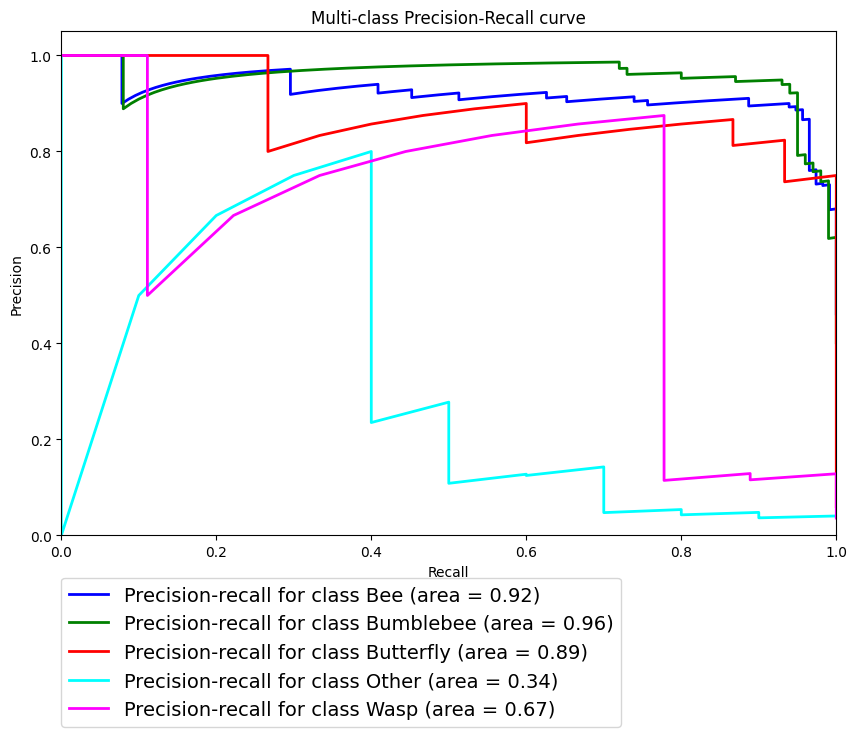

In [ ]:
lda = imbPipeline([ 
    ('scaler', DataFrameStandardScaler()),
    ('smote', smote),
    ('feature_selector', feature_selector),
    ('model', LinearDiscriminantAnalysis())
    ])
lda.set_params(**{'model__shrinkage': 0.16161616161616163, 'model__solver': 'lsqr', 'smote__k_neighbors': 3, 'feature_selector__feature_flags': {'aspect_ratio': 0, 'axis_least_inertia_x': 0, 'axis_least_inertia_y': 1, 'blue_contrast': 1, 'blue_mask_max': 0, 'blue_mask_mean': 1, 'blue_mask_median': 1, 'blue_mask_min': 0, 'blue_mask_q1': 1, 'blue_mask_q3': 0, 'blue_mask_std': 0, 'blue_rest_max': 1, 'blue_rest_mean': 0, 'blue_rest_median': 1, 'blue_rest_min': 1, 'blue_rest_q1': 0, 'blue_rest_q3': 0, 'blue_rest_std': 0, 'body_parts_max_length': 1, 'body_parts_mean_length': 1, 'body_parts_spread': 0, 'body_parts_std_length': 0, 'ellipse_angle': 0, 'ellipse_axis_ratio': 1, 'ellipse_eccentricity': 0, 'ellipse_variance': 1, 'fourier_descriptor_imag_0': 0, 'fourier_descriptor_imag_1': 0, 'fourier_descriptor_imag_2': 0, 'fourier_descriptor_imag_3': 0, 'fourier_descriptor_imag_4': 0, 'fourier_descriptor_imag_5': 0, 'fourier_descriptor_imag_6': 1, 'fourier_descriptor_imag_7': 1, 'fourier_descriptor_imag_8': 0, 'fourier_descriptor_imag_9': 1, 'fourier_descriptor_real_0': 1, 'fourier_descriptor_real_1': 0, 'fourier_descriptor_real_2': 0, 'fourier_descriptor_real_3': 0, 'fourier_descriptor_real_4': 0, 'fourier_descriptor_real_5': 0, 'fourier_descriptor_real_6': 0, 'fourier_descriptor_real_7': 0, 'fourier_descriptor_real_8': 1, 'fourier_descriptor_real_9': 1, 'green_mask_max': 1, 'green_mask_mean': 0, 'green_mask_median': 1, 'green_mask_min': 0, 'green_mask_q1': 0, 'green_mask_q3': 1, 'green_mask_std': 1, 'green_rest_max': 1, 'green_rest_mean': 0, 'green_rest_median': 1, 'green_rest_min': 0, 'green_rest_q1': 0, 'green_rest_q3': 1, 'green_rest_std': 0, 'hue_mask_max': 0, 'hue_mask_mean': 1, 'hue_mask_median': 1, 'hue_mask_q1': 0, 'hue_mask_q3': 0, 'hue_mask_std': 1, 'hue_rest_max': 1, 'hue_rest_mean': 1, 'hue_rest_median': 0, 'hue_rest_q1': 0, 'hue_rest_q3': 0, 'hue_rest_std': 1, 'hull_area': 1, 'hull_convexity': 1, 'hull_to_insect_area_ratio': 0, 'hull_to_insect_area_ratio_x_value_mask_std': 1, 'hull_triangle_similarity': 1, 'image_symmetry_index': 1, 'kurtosis_centroid_distance': 1, 'mask_area': 0, 'mask_bb_symmetry_index': 1, 'mask_entropy': 1, 'mask_perimeter': 1, 'max_centroid_distance': 0, 'mean_centroid_distance': 1, 'mean_centroid_distance_x_max_centroid_distance': 1, 'min_centroid_distance': 1, 'min_centroid_distance_x_rectangularity': 0, 'nb_pixels_ratio': 0, 'nb_pixels_ratio_div_hull_triangle_similarity': 1, 'orthogonal_lines_ratio': 1, 'rectangularity': 0, 'red_mask_max': 0, 'red_mask_mean': 0, 'red_mask_median': 1, 'red_mask_min': 0, 'red_mask_q1': 0, 'red_mask_q3': 0, 'red_mask_std': 1, 'red_rest_max': 1, 'red_rest_mean': 0, 'red_rest_median': 0, 'red_rest_min': 1, 'red_rest_q1': 0, 'red_rest_q3': 0, 'red_rest_std': 1, 'rest_entropy': 1, 'roundness': 0, 'roundness_div_hull_area': 1, 'saturation_mask_max': 0, 'saturation_mask_mean': 0, 'saturation_mask_median': 1, 'saturation_mask_min': 1, 'saturation_mask_q1': 1, 'saturation_mask_q3': 1, 'saturation_mask_std': 1, 'saturation_rest_max': 0, 'saturation_rest_mean': 1, 'saturation_rest_median': 1, 'saturation_rest_min': 1, 'saturation_rest_q1': 1, 'saturation_rest_q3': 0, 'saturation_rest_std': 1, 'saturation_weighted_aspect_ratio': 1, 'shape_texture_index': 1, 'skewness_centroid_distance': 0, 'std_centroid_distance': 1, 'value_mask_max': 0, 'value_mask_mean': 0, 'value_mask_median': 0, 'value_mask_min': 0, 'value_mask_q1': 0, 'value_mask_q3': 1, 'value_mask_std': 0, 'value_rest_max': 1, 'value_rest_mean': 1, 'value_rest_median': 0, 'value_rest_min': 1, 'value_rest_q1': 0, 'value_rest_q3': 1, 'value_rest_std': 1}}
)
evaluate_classifier(lda, X, y5, n_jobs=-1, plot=False)

[0 1 2 3 4]
Accuracy: 0.8473895582329317
Precision: 0.8207580287043178
Recall: 0.8473895582329317
F1 Score: 0.8298423442982559
              precision    recall  f1-score   support

         Bee       0.82      0.93      0.87       115
   Bumblebee       0.90      0.89      0.89       100
   Butterfly       0.77      0.67      0.71        15
       Other       0.00      0.00      0.00        10
        Wasp       1.00      0.56      0.71         9

    accuracy                           0.85       249
   macro avg       0.70      0.61      0.64       249
weighted avg       0.82      0.85      0.83       249



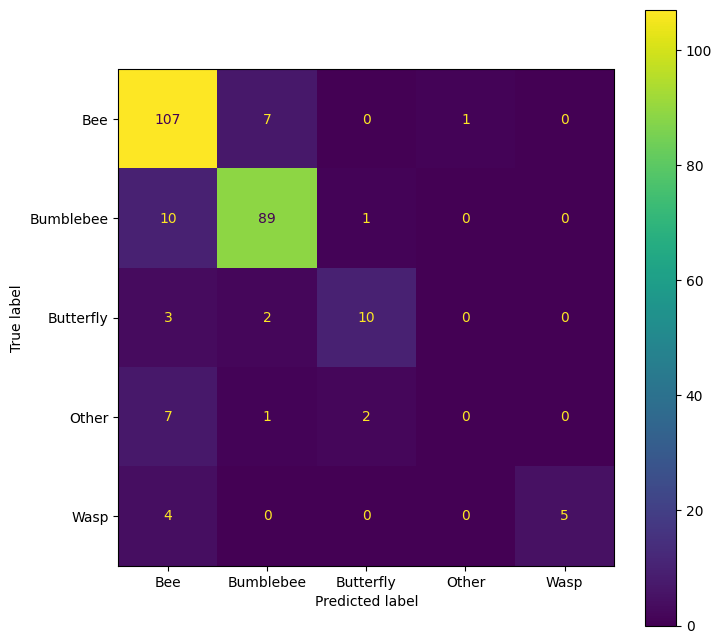

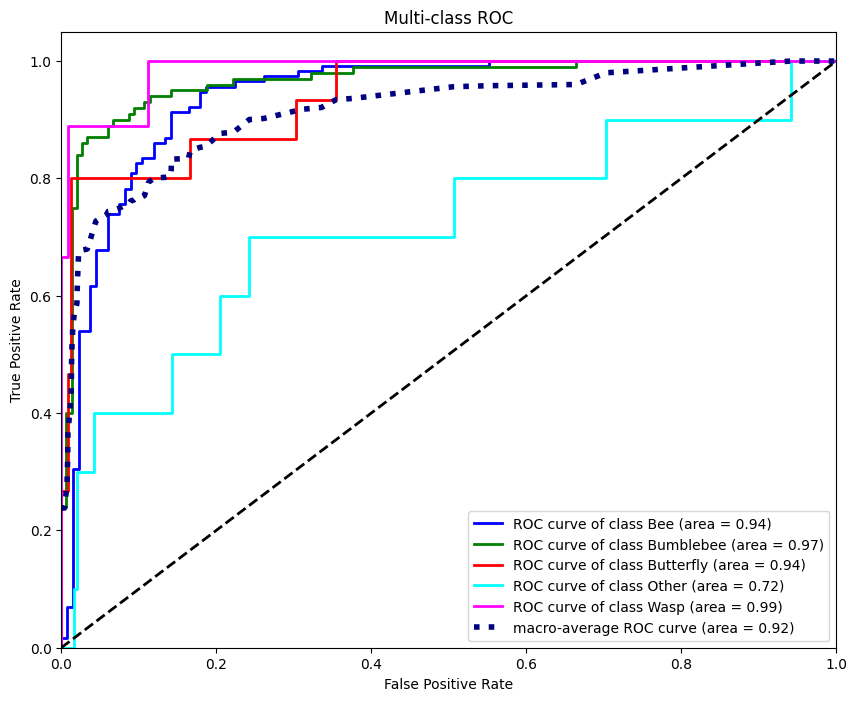

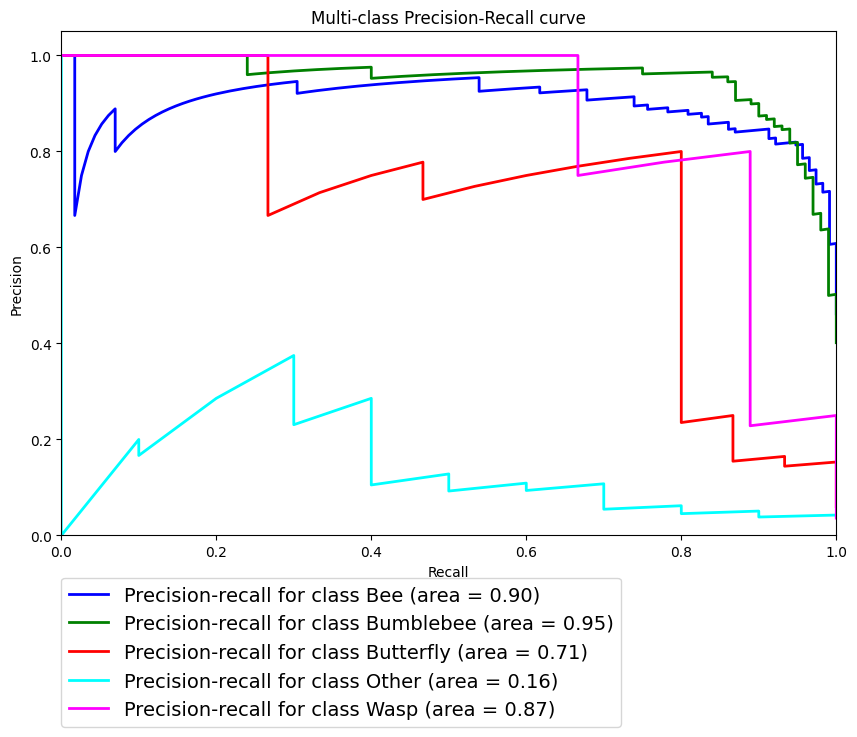

In [ ]:
xgb = imbPipeline([ 
    ('scaler', DataFrameStandardScaler()),
    ('smote', smote),
    ('feature_selector', feature_selector),
    ('model', XGBClassifier(random_state=RANDOM_STATE))
    ])
{'model__colsample_bytree': 0.7163916260887613, 'model__learning_rate': 0.053142125789746426, 'model__max_depth': 37, 'model__min_child_weight': 2, 'model__n_estimators': 231, 'model__subsample': 0.7666477970924599, 'smote__k_neighbors': 4, 'feature_selector__feature_flags': {'aspect_ratio': 0, 'axis_least_inertia_x': 0, 'axis_least_inertia_y': 0, 'blue_contrast': 0, 'blue_mask_max': 0, 'blue_mask_mean': 0, 'blue_mask_median': 0, 'blue_mask_min': 0, 'blue_mask_q1': 0, 'blue_mask_q3': 1, 'blue_mask_std': 0, 'blue_rest_max': 0, 'blue_rest_mean': 1, 'blue_rest_median': 1, 'blue_rest_min': 0, 'blue_rest_q1': 1, 'blue_rest_q3': 1, 'blue_rest_std': 0, 'body_parts_max_length': 1, 'body_parts_mean_length': 0, 'body_parts_spread': 0, 'body_parts_std_length': 0, 'ellipse_angle': 0, 'ellipse_axis_ratio': 0, 'ellipse_eccentricity': 1, 'ellipse_variance': 1, 'fourier_descriptor_imag_0': 0, 'fourier_descriptor_imag_1': 1, 'fourier_descriptor_imag_2': 1, 'fourier_descriptor_imag_3': 1, 'fourier_descriptor_imag_4': 1, 'fourier_descriptor_imag_5': 0, 'fourier_descriptor_imag_6': 0, 'fourier_descriptor_imag_7': 0, 'fourier_descriptor_imag_8': 0, 'fourier_descriptor_imag_9': 0, 'fourier_descriptor_real_0': 0, 'fourier_descriptor_real_1': 0, 'fourier_descriptor_real_2': 1, 'fourier_descriptor_real_3': 1, 'fourier_descriptor_real_4': 0, 'fourier_descriptor_real_5': 1, 'fourier_descriptor_real_6': 1, 'fourier_descriptor_real_7': 1, 'fourier_descriptor_real_8': 0, 'fourier_descriptor_real_9': 1, 'green_mask_max': 1, 'green_mask_mean': 0, 'green_mask_median': 1, 'green_mask_min': 1, 'green_mask_q1': 0, 'green_mask_q3': 1, 'green_mask_std': 1, 'green_rest_max': 0, 'green_rest_mean': 0, 'green_rest_median': 0, 'green_rest_min': 0, 'green_rest_q1': 0, 'green_rest_q3': 0, 'green_rest_std': 0, 'hue_mask_max': 0, 'hue_mask_mean': 1, 'hue_mask_median': 1, 'hue_mask_q1': 1, 'hue_mask_q3': 0, 'hue_mask_std': 1, 'hue_rest_max': 1, 'hue_rest_mean': 1, 'hue_rest_median': 1, 'hue_rest_q1': 0, 'hue_rest_q3': 0, 'hue_rest_std': 1, 'hull_area': 1, 'hull_convexity': 0, 'hull_to_insect_area_ratio': 0, 'hull_to_insect_area_ratio_x_value_mask_std': 0, 'hull_triangle_similarity': 0, 'image_symmetry_index': 1, 'kurtosis_centroid_distance': 0, 'mask_area': 0, 'mask_bb_symmetry_index': 0, 'mask_entropy': 0, 'mask_perimeter': 1, 'max_centroid_distance': 0, 'mean_centroid_distance': 1, 'mean_centroid_distance_x_max_centroid_distance': 1, 'min_centroid_distance': 1, 'min_centroid_distance_x_rectangularity': 1, 'nb_pixels_ratio': 1, 'nb_pixels_ratio_div_hull_triangle_similarity': 0, 'orthogonal_lines_ratio': 1, 'rectangularity': 0, 'red_mask_max': 0, 'red_mask_mean': 0, 'red_mask_median': 1, 'red_mask_min': 1, 'red_mask_q1': 0, 'red_mask_q3': 1, 'red_mask_std': 0, 'red_rest_max': 0, 'red_rest_mean': 0, 'red_rest_median': 1, 'red_rest_min': 1, 'red_rest_q1': 1, 'red_rest_q3': 0, 'red_rest_std': 0, 'rest_entropy': 1, 'roundness': 0, 'roundness_div_hull_area': 1, 'saturation_mask_max': 0, 'saturation_mask_mean': 1, 'saturation_mask_median': 1, 'saturation_mask_min': 1, 'saturation_mask_q1': 1, 'saturation_mask_q3': 1, 'saturation_mask_std': 1, 'saturation_rest_max': 0, 'saturation_rest_mean': 0, 'saturation_rest_median': 1, 'saturation_rest_min': 0, 'saturation_rest_q1': 0, 'saturation_rest_q3': 1, 'saturation_rest_std': 1, 'saturation_weighted_aspect_ratio': 1, 'shape_texture_index': 1, 'skewness_centroid_distance': 1, 'std_centroid_distance': 0, 'value_mask_max': 0, 'value_mask_mean': 1, 'value_mask_median': 1, 'value_mask_min': 1, 'value_mask_q1': 1, 'value_mask_q3': 0, 'value_mask_std': 1, 'value_rest_max': 0, 'value_rest_mean': 1, 'value_rest_median': 1, 'value_rest_min': 0, 'value_rest_q1': 1, 'value_rest_q3': 0, 'value_rest_std': 1}}
xgb.set_params(**{'model__colsample_bytree': 0.7163916260887613, 'model__learning_rate': 0.053142125789746426, 'model__max_depth': 37, 'model__min_child_weight': 2, 'model__n_estimators': 231, 'model__subsample': 0.7666477970924599})
evaluate_classifier(xgb, X, y5, n_jobs=-1, plot=False)

In [ ]:
#### (Old code)
net_search_space = {
    'num_layers': hp.choice('num_layers', np.arange(1, 15, 1, dtype=int)),  # choose between the number of layers
    'units_per_layer': hp.choice('units_per_layer', [
        [hp.randint(f'units_layer_{i}_{j}', 20, 150) for i in range(j)]  # each layer can have between 50 to 150 units
        for j in range(1, 5)  # corresponding to the number of layers chosen
    ]),
    'epochs': hp.uniformint('epochs', 5, 25),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    #'activation': hp.choice('activation', [nn.ReLU(), nn.Tanh()]),
    #'dropout': hp.loguniform('dropout', 1e-5, 0.1)
}

net = imbPipeline([
    ('dim_reductor', big_dim_reductor),
    ('scaler', StandardScaler()),
    ('smote', smote),
    ('model', PyTorchClassifier(input_size, n_classes, layers_sizes))
])
best_params = optimize_classifier(X, y5, net, net_search_space, {}, max_evals=1, scoring='accuracy',n_jobs=1, debug=True)
evaluate_classifier(net, X, y5)

Search space: {'model__num_layers': <hyperopt.pyll.base.Apply object at 0x00000215D9FE26D0>, 'model__units_per_layer': <hyperopt.pyll.base.Apply object at 0x00000215DE341090>, 'model__epochs': <hyperopt.pyll.base.Apply object at 0x00000215E2A473D0>, 'model__learning_rate': <hyperopt.pyll.base.Apply object at 0x00000215DE781BD0>}
[0 1 2 3 4]
units per layer detected                             
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

job exception: tuple index out of range



  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]


IndexError: tuple index out of range